In [19]:
from utils.base_helpers import download_artifact
import pandas as pd
import wandb


In [2]:
wandb.init(project="keras")

wandb: Currently logged in as: merts (use `wandb login --relogin` to force relogin)
2022-05-24 14:38:51.401244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 14:38:51.401262: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [26]:
def artifacts(wandb_id):
    predictions = download_artifact(f'merts/keras/run-{wandb_id}-test_predictions:v0')
    wmape = download_artifact(f'merts/keras/run-{wandb_id}-test_wmape_table:v0')
    wmape_month = download_artifact(f'merts/keras/run-{wandb_id}-test_wmape_month_table:v0')
    return {"predictions": predictions, "wmape": wmape, "wmape_month": wmape_month}

In [27]:
mlp1 = artifacts("1wo20kk5")
mlp2 = artifacts("1rdg2wjz")
mlp3 = artifacts("olozkfwl")
mlp4 = artifacts("lgzwtmz0")

In [28]:
cnn1 = artifacts("2pw2oafo")
cnn2 = artifacts("2ni8q5zy")
cnn3 = artifacts("eix3jddl")
cnn4 = artifacts("g55nqmkk")

In [29]:
mlp = pd.concat([mlp1["wmape_month"], mlp2["wmape_month"], mlp3["wmape_month"], mlp4["wmape_month"]])

In [30]:
cnn = pd.concat([cnn1["wmape_month"], cnn2["wmape_month"], cnn3["wmape_month"], cnn4["wmape_month"]])

In [31]:
cnn

,month,rt_plant_id,wmape
0,202101,672,0.272358
1,202101,757,0.236709
2,202101,968,0.266417
3,202101,969,0.414532
4,202101,1194,0.395365
...,...,...,...
265,202112,2288,0.380304
266,202112,2291,0.416933
267,202112,2323,0.254283
268,202112,2326,0.237421


<AxesSubplot:xlabel='forecast_dt'>

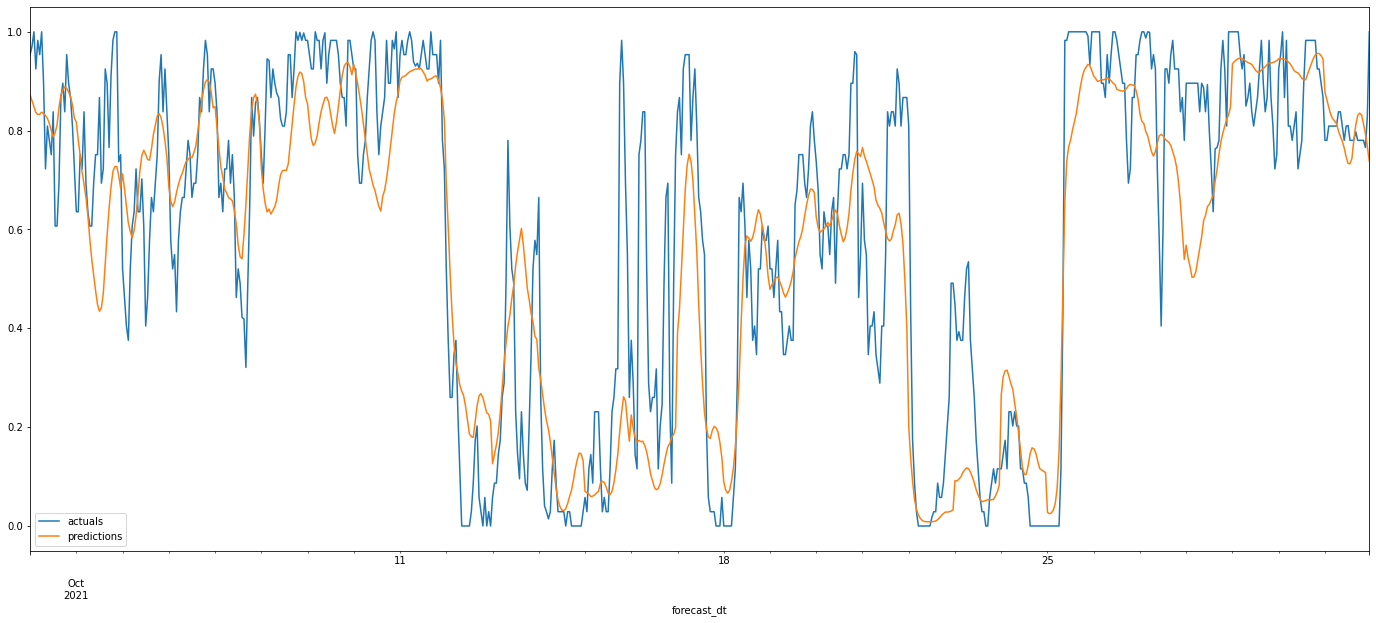

In [72]:
mlp4["predictions"][mlp4["predictions"].forecast_dt.dt.month == 10].query("rt_plant_id == 1513").set_index("forecast_dt")[["actuals", "predictions"]].plot(figsize=(24,10))

<AxesSubplot:xlabel='forecast_dt'>

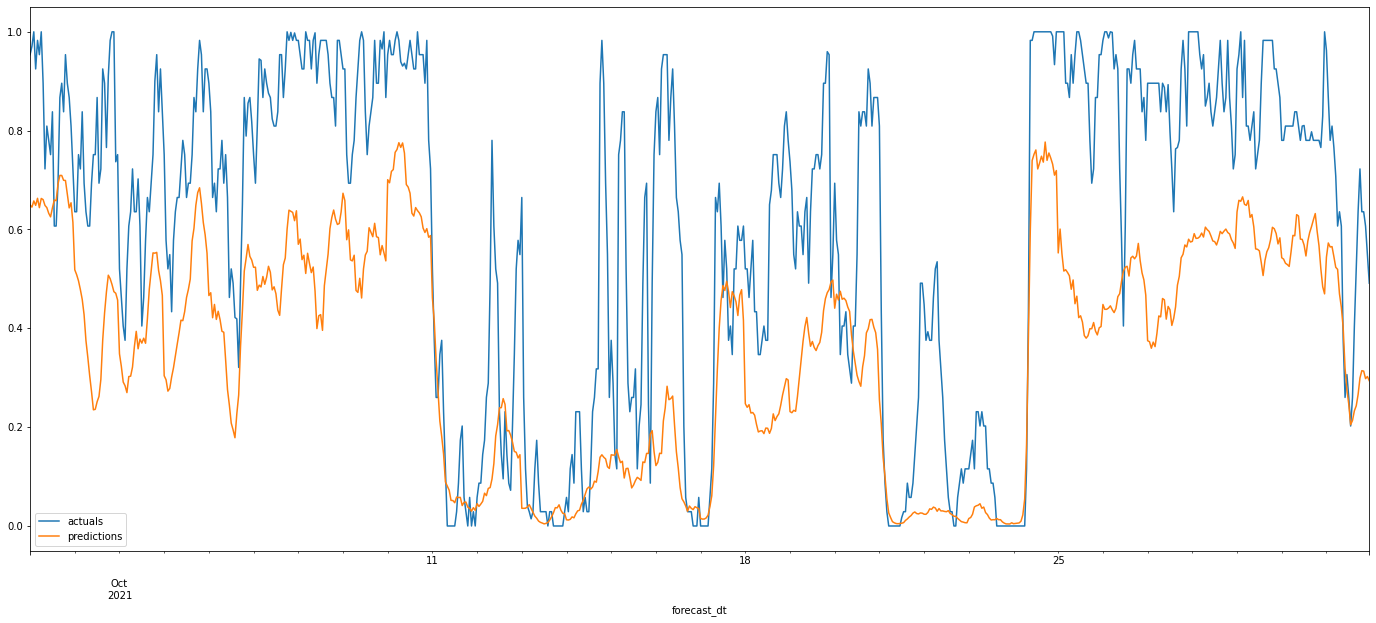

wandb: Network error (ConnectionError), entering retry loop.


In [73]:
cnn4["predictions"][cnn4["predictions"].forecast_dt.dt.month == 10].query("rt_plant_id == 1513").set_index("forecast_dt")[["actuals", "predictions"]].plot(figsize=(24,10))

In [33]:
mlp = mlp.rename(columns={"wmape": "wmape_mlp"})
cnn = cnn.rename(columns={"wmape": "wmape_cnn"})
metrics = pd.merge(mlp, cnn, on=["month", "rt_plant_id"])
metrics["diff"] = metrics["wmape_cnn"] / metrics["wmape_mlp"]

In [52]:
metrics.groupby("month")[["wmape_mlp", "wmape_cnn"]].mean()

,wmape_mlp,wmape_cnn
month,,
202101,0.377243,0.332694
202102,0.373740,0.329318
202103,0.374882,0.324764
202104,0.412713,0.366094
202105,0.483378,0.402612
202106,0.546225,0.475144
202107,0.284564,0.259991
202108,0.336670,0.288837
202109,0.335186,0.275574


<AxesSubplot:xlabel='month'>

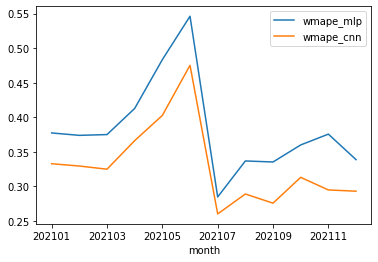

In [38]:
metrics.groupby("month")[["wmape_mlp", "wmape_cnn"]].mean().plot()

In [56]:
metrics[metrics["rt_plant_id"] == 1513]

,month,rt_plant_id,wmape_mlp,wmape_cnn,diff
31,202101,1513,0.331265,0.425022,1.283028
121,202102,1513,0.466554,0.514256,1.102244
211,202103,1513,0.332900,0.466650,1.401770
301,202104,1513,0.411953,0.556752,1.351493
391,202105,1513,0.469604,0.579199,1.233379
481,202106,1513,0.588348,0.691878,1.175967
571,202107,1513,0.315280,0.509143,1.614894
661,202108,1513,0.331430,0.419148,1.264662
751,202109,1513,0.349222,0.414125,1.185852
841,202110,1513,0.220606,0.434139,1.967941


In [50]:
metrics.groupby("rt_plant_id")[["wmape_mlp", "wmape_cnn", "diff"]].mean().sort_values("wmape_cnn")

,wmape_mlp,wmape_cnn,diff
rt_plant_id,,,
2112,0.276981,0.250351,0.904505
2058,0.287222,0.258542,0.899456
2288,0.334189,0.261515,0.777726
2073,0.314298,0.265226,0.849691
1761,0.303715,0.265679,0.884270
...,...,...,...
1929,0.524792,0.429313,0.831597
1524,0.437737,0.448125,1.031703
2089,0.535223,0.485222,0.910107


In [51]:
metrics.mean()

month                  inf
rt_plant_id    1735.288889
wmape_mlp         0.383215
wmape_cnn         0.329630
diff              0.869961
dtype: float64